In [1]:
import torch 
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

from attrdict import AttrDict
import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
args = AttrDict()
args.seeds = 1111

In [3]:
random_seed = args.seeds
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:

# class Linear_MCdrop(nn.Module):
#     """Linear Layer where activations are sampled from a fully factorised normal which is given by aggregating
#      the moments of each weight's normal distribution. The KL divergence is obtained in closed form. Only works
#       with gaussian priors.
#     """
#     def __init__(self, n_in, n_out, prior_sig=0.1**2):
#         super(Linear_MCdrop, self).__init__()
#         self.n_in = n_in
#         self.n_out = n_out
#         self.prior_sig = prior_sig

#         # Learnable parameters
#         self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.1, 0.1))        
#         torch.nn.init.xavier_uniform(self.W_mu.data)
#         #self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).xavier_uniform_())        
#         self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-6, -5))

#         self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-1e-8, 1e-8))
#         self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(-6, -5))
#         self.bias = True

#     def forward(self, X, sample=False):
#         #         print(self.training)

#         if not self.training and not sample:  # This is just a placeholder function
#             #print('check weight sampling x')            
#             output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_out)
#             return output, 0, 0

#         else:
#             #print('check weight sampling o')
#             # calculate std
#             std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20)
#             std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20)

#             act_W_mu = torch.mm(X, self.W_mu)  # self.W_mu + std_w * eps_W
#             act_W_std = torch.sqrt(torch.mm(X.pow(2), std_w.pow(2)))

#             # Tensor.new()  Constructs a new tensor of the same data type as self tensor.
#             # the same random sample is used for every element in the minibatch output
#             eps_W = Variable(self.W_mu.data.new(act_W_std.size()).normal_(mean=0, std=1))
#             eps_b = Variable(self.b_mu.data.new(std_b.size()).normal_(mean=0, std=1))

#             act_W_out = act_W_mu + act_W_std * eps_W  # (batch_size, n_output)
#             act_b_out = self.b_mu + std_b * eps_b

#             output = act_W_out + act_b_out.unsqueeze(0).expand(X.shape[0], -1)

#             kld = KLD_cost(mu_p=0, sig_p=self.prior_sig, mu_q=self.W_mu, sig_q=std_w)  
#             kld = kld + KLD_cost(mu_p=0, sig_p=0.1, mu_q=self.b_mu,sig_q=std_b)
#             return output, kld, 0

#     def extra_repr(self) -> str:
#         return 'in_features={}, out_features={}, bias={}'.format(
#             self.n_in, self.n_out, self.bias is not None
#         )        
    

In [5]:
def MC_dropout(act_vec, p=0.5, mask=True):
    return F.dropout(act_vec, p=p, training=mask, inplace=True)


class MLP_Layer_MCdrop(nn.Module):
    def __init__(self,in_dim=1,out_dim=1,hdim = 50 , p=0.01):
        super(MLP_Layer_MCdrop,self).__init__()

        #self.in_dim = in_dim + 1
        self.in_dim = in_dim + 1        
        self.out_dim = out_dim
        self.hdim = hdim

        self.p = p
        linear1 = nn.Linear(self.in_dim,self.hdim)
        #dropout1 = nn.Dropout(self.p)
        linear2 = nn.Linear(self.hdim,self.hdim)
        dropout2 = nn.Dropout(self.p)        
        linear3 = nn.Linear(self.hdim,self.hdim)
        dropout3 = nn.Dropout(self.p)        
        linear4 = nn.Linear(self.hdim,self.out_dim)

        activation =  nn.Tanh()
        linear = [linear1,
                  activation,
                  #dropout1,                  
                  linear2,
                  activation,
                  dropout2,                                    
                  linear3,
                  activation,
                  dropout3,                                                      
                  linear4]
        self.linear = nn.Sequential(*linear)
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.0)
                
        self.linear.apply(init_weights)
        
                
    def forward(self,x):        
        return self.linear(x)
    
    
    
class PINN_Basic(nn.Module):
    def __init__(self,nn_model, pdetype = 'v1' ):
        super(PINN_Basic,self).__init__()

        self.pde_type = pdetype
        self.nn_model = nn_model
        self.in_dim =  nn_model.in_dim         
        self.out_dim = nn_model.out_dim
        self.reg_lambda = 1
        
        #self.mse_loss = nn.MSELoss(reduce=False)
        self.mse_loss = nn.MSELoss(reduce=True,reduction = 'mean')
            
    def forward(self,xt):        
        u_xt = self.nn_model(xt)                
        return u_xt
    
    
    def compute_loss(self,xt_rd,y_rd,xt_init,u_init,xt_bd,u_bd):
        loss_rd = self.compute_pdeloss_rd(xt_rd,y_rd)
        loss_init = self.compute_pdeloss_bdinit(xt_init,u_init)
        loss_bd = self.compute_pdeloss_bdinit(xt_bd,u_bd)        
        #loss = loss_rd + self.reg_lambda*(0.5*loss_init + 0.5*loss_bd)
        #return loss_rd + self.reg_lambda*(0.5*loss_init + 0.5*loss_bd)
        return loss_rd,loss_init,loss_bd


    
    def compute_pdeloss_rd(self,xt,y):        
        xt_grad = xt.clone()
        xt_grad.requires_grad = True

        u = self.nn_model(xt_grad)                
        du_dxt= autograd.grad(u,xt_grad,torch.ones_like(u).to(u.device),retain_graph=True,create_graph=True)[0]
        du_dx_dxt = autograd.grad(du_dxt[:,:,:-1],xt_grad,torch.ones_like(du_dxt[:,:,:-1]).to(xt_grad.device),retain_graph=True,create_graph=True)[0]
        du_dx = du_dxt[:,:,:-1]
        du_dxx = du_dx_dxt[:,:,:-1]

        # compute loss depending on pde
        pde_loss = self.mse_loss(0.01*du_dxx,y)
        
        return pde_loss
    
    
    def compute_pdeloss_bdinit(self,xt,y):        
        u = self.nn_model(xt)                
        # compute loss depending on pde
        pde_loss = self.mse_loss(u,y)
        
        return pde_loss

In [6]:
#--------------------------------------------------------
# reference:
# https://github.com/JavierAntoran/Bayesian-Neural-Networks/blob/master/src/MC_dropout/model.py
# https://github.com/JavierAntoran/Bayesian-Neural-Networks/blob/master/notebooks/regression/mc_dropout_homo.ipynb
#--------------------------------------------------------
class PINN_MCdrop(PINN_Basic):
    
    def __init__(self,nn_model, pdetype = 'v1',num_sample_intrain=5, num_sample_intest=10, eps=1e-16):
    #def __init__(self,in_dim = 1, out_dim = 1, pdetype = 'v1',num_sample_intrain=5, num_sample_intest=10, eps=1e-16):
        
        super(PINN_MCdrop,self).__init__(nn_model, pdetype)

        #self.nn_model =  BayesMLP_Layer(in_dim = in_dim,out_dim = out_dim)
        self.num_sample_intrain = num_sample_intrain
        self.num_sample_intest = num_sample_intest

    def compute_preddist(self,xt,num_sample=10):        
        pred_list = []
        for _ in range(num_sample):
            pred_list.append(self.forward(xt)[0].unsqueeze(dim=-1))
        pred_list = torch.cat(pred_list,dim=-1)    
        emp_pmu = pred_list.mean(dim=-1) 
        emp_pstd = pred_list.std(dim=-1) 
        
        #return emp_pmu,emp_pstd,pred_list
        return emp_pmu,emp_pstd

    

    def forward(self,xt,use_sample=True):        
        if use_sample:
            self.nn_model.train()
        else:
            self.nn_model.eval()            
        u_xt = self.nn_model(xt)                            
        return u_xt, 0.0
    

    def compute_loss(self,xt_rd,y_rd,xt_init,u_init,xt_bd,u_bd):
        loss_rd,reg_rd = 0,0
        loss_init,reg_init = 0,0
        loss_bd,reg_bd = 0,0
        
        for i in range(self.num_sample_intrain):        
            i_loss_rd,i_reg_rd      = self.compute_pdeloss_rd(xt_rd,y_rd)            
            loss_rd = loss_rd + i_loss_rd
            reg_rd = reg_rd + i_reg_rd
            
            i_loss_init,i_reg_init  = self.compute_pdeloss_bdinit(xt_init,u_init)
            loss_init = loss_init + i_loss_init
            reg_init = reg_init + i_reg_init

            i_loss_bd,i_reg_bd      = self.compute_pdeloss_bdinit(xt_bd,u_bd)        
            loss_bd = loss_bd + i_loss_bd
            reg_bd = reg_bd + i_reg_bd
            
        loss_rd, reg_rd = loss_rd/self.num_sample_intrain, reg_rd/self.num_sample_intrain    
        loss_init, reg_init = loss_init/self.num_sample_intrain, reg_init/self.num_sample_intrain    
        loss_bd, reg_bd = loss_bd/self.num_sample_intrain, reg_bd/self.num_sample_intrain    
        
        return (loss_rd,reg_rd),(loss_init,reg_init),(loss_bd,reg_bd)

    
    def compute_pdeloss_rd(self,xt,y):        
        xt_grad = xt.clone()
        xt_grad.requires_grad = True

#         u, tlqw, tlpw = self.nn_model(xt_grad)                
#         # ------------------------------        
#         # compute regloss by prior
#         # ------------------------------        
#         nbatch = np.prod(xt_bd.shape[:2])
#         reg_loss = (tlqw - tlpw)/nbatch

        u = self.nn_model(xt_grad)                

        # ------------------------------
        # compute pde bd loss
        # ------------------------------        
        du_dxt= autograd.grad(u,xt_grad,torch.ones_like(u).to(u.device),retain_graph=True,create_graph=True)[0]
        du_dx_dxt = autograd.grad(du_dxt[:,:,:-1],xt_grad,torch.ones_like(du_dxt[:,:,:-1]).to(xt_grad.device),retain_graph=True,create_graph=True)[0]
        du_dx = du_dxt[:,:,:-1]
        du_dxx = du_dx_dxt[:,:,:-1]

        # compute loss depending on pde
        pde_loss = self.mse_loss(0.01*du_dxx,y)
            
        return pde_loss,0.0
    
    
    def compute_pdeloss_bdinit(self,xt,y):        
#         u, tlqw, tlpw = self.nn_model(xt)
#         # ------------------------------
#         # compute regloss by prior        
#         # ------------------------------        
#         nbatch = np.prod(xt_bd.shape[:2])
#         reg_loss = (tlqw - tlpw)/nbatch

        u = self.nn_model(xt)

        # ------------------------------
        # compute pde init loss
        # ------------------------------                
        # compute loss depending on pde
        pde_loss = self.mse_loss(u,y)
        
        return pde_loss,0.0    


In [7]:
#nn.Dropout(self.p)  

## target problem: 1d nonlinear Poisson equation

In [8]:
#torch.linspace(init_a,init_b,nobs)

In [9]:
#---------------------------------
# data configuration
#---------------------------------
dataconfig = AttrDict()

dataconfig.in_dim,dataconfig.out_dim  = 1,1
dataconfig.noisestd = 0.1
#dataconfig.noisestd = 0.01

#nb,nobs = 16,16 #(nsensors=16)

dataconfig.nb,dataconfig.nobs = 8,32 #(nsensors=32)

dataconfig.xmin,dataconfig.xmax = -0.7,0.7
dataconfig.tmin,dataconfig.tmax = 0,1

dataconfig

AttrDict({'in_dim': 1, 'out_dim': 1, 'noisestd': 0.1, 'nb': 8, 'nobs': 32, 'xmin': -0.7, 'xmax': 0.7, 'tmin': 0, 'tmax': 1})

In [10]:





#---------------------------------
# rc
#---------------------------------
#def gen_obs(xmin=xmin,xmax=xmax,tmin=,noise_level=0.1):
#def gen_obs(xmin=xmin,xmax=xmax,tmin=,noise_level=0.1):
# def gen_obs(dataconfig):
    
#     f = lambda x: torch.pow(torch.sin(6*x),3)
  
#     x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
#     g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
#     t = (dataconfig.tmax  - dataconfig.tmin)* torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)

#     f = f(x)
#     y = f + g_noise 

#     #return x,y,f    
#     #t = (dataconfig.tmax  - dataconfig.tmin)* torch.rand(dataconfig.nb,dataconfig.nobs,1 )
    
#     xt = torch.cat([x,t],dim=-1)
#     return xt,y,f    



def gen_obs(dataconfig):
    
    u = lambda x: torch.pow(torch.sin(6*x),3)
    f = lambda x: (6**3)*torch.sin(6*x)*torch.pow(torch.cos(6*x),2) - 3*(6**2)*torch.pow(torch.sin(6*x),3)
  
    # ----------------------------
    # gen datset on rd
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = (dataconfig.tmax  - dataconfig.tmin)* torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)

    f_xt = f(x)
    y_rd = 0.01*f_xt + g_noise     
    xt_rd = torch.cat([x,t],dim=-1)
    

    # ----------------------------
    # gen datset on init
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = 0*torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)
    u_init = u(x)
    xt_init = torch.cat([x,t],dim=-1)

    # ----------------------------
    # gen datset on bd
    # ----------------------------    
    x = torch.cat([dataconfig.xmin* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim ),
                   dataconfig.xmax* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim )],dim=-2)
     
    #g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = torch.rand(dataconfig.nb,dataconfig.nobs,1  )
    u_bd = u(x)
    #y_bd = u_bd      
    xt_bd = torch.cat([x,t],dim=-1)
        
    return (xt_rd,y_rd,f_xt),(xt_init,u_init),(xt_bd,u_bd)    


    

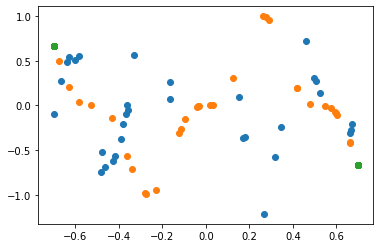

In [11]:
rd_set,init_set,bd_set = gen_obs(dataconfig)

xt_rd,y_rd,f = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

bidx = 1
plt.scatter(xt_rd[bidx,:,0].cpu().data.numpy(),y_rd[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_init[bidx,:,0].cpu().data.numpy(),u_init[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_bd[bidx,:,0].cpu().data.numpy(),u_bd[bidx,:,0].cpu().data.numpy())

#plt.scatter(xt_init[:,0].cpu().data.numpy(),u_init[:,0].cpu().data.numpy())
# plt.scatter(xt[:,0].cpu().data.numpy(),f[:,0].cpu().data.numpy())


In [12]:
#len(rd_set[:-1])

In [13]:
# mlp_layer = MLP_Layer(in_dim = 1, out_dim=1)
# mlp_layer
#model = PINN_Basic( MLP_Layer(in_dim = 1, out_dim=1) )
#model = PINN_Basic( MLP_Layer_MCdrop(in_dim = 1, out_dim=1) )
model = PINN_MCdrop( MLP_Layer_MCdrop(in_dim = 1, out_dim=1, p=0.05) )
model

/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/yohan/Myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


PINN_MCdrop(
  (nn_model): MLP_Layer_MCdrop(
    (linear): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Tanh()
      (4): Dropout(p=0.05, inplace=False)
      (5): Linear(in_features=50, out_features=50, bias=True)
      (6): Tanh()
      (7): Dropout(p=0.05, inplace=False)
      (8): Linear(in_features=50, out_features=1, bias=True)
    )
  )
  (mse_loss): MSELoss()
)

In [16]:
trainconfig = AttrDict()

trainconfig.nepochs = 2000
trainconfig.lr = 1e-3
trainconfig.weightdecay = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=trainconfig.lr,weight_decay=trainconfig.weightdecay)


In [17]:
model.train()
for j in range(1,trainconfig.nepochs+1):
    rd_set,init_set,bd_set = gen_obs(dataconfig)
    loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set[:-1],*init_set,*bd_set)
    
    loss = loss_rd[0] + 0.5*(loss_init[0] + loss_bd[0]) 
    
    if j % 100 == 0:
        print('[{} /{}]: tr loss: {:.2f} \t {:.2f},{:.2f},{:.2f}'.format(j,trainconfig.nepochs,loss,loss_rd[0],loss_init[0],loss_bd[0]))
    
    #update model params
    optimizer.zero_grad()        
    loss.backward()
    optimizer.step()



[100 /2000]: tr loss: 0.45 	 0.34,0.15,0.06
[200 /2000]: tr loss: 0.32 	 0.27,0.08,0.04
[300 /2000]: tr loss: 0.29 	 0.24,0.06,0.04
[400 /2000]: tr loss: 0.23 	 0.18,0.05,0.05
[500 /2000]: tr loss: 0.20 	 0.15,0.04,0.05
[600 /2000]: tr loss: 0.21 	 0.16,0.05,0.04
[700 /2000]: tr loss: 0.18 	 0.13,0.04,0.05
[800 /2000]: tr loss: 0.16 	 0.12,0.04,0.04
[900 /2000]: tr loss: 0.16 	 0.12,0.04,0.04
[1000 /2000]: tr loss: 0.13 	 0.10,0.04,0.04
[1100 /2000]: tr loss: 0.13 	 0.10,0.04,0.04
[1200 /2000]: tr loss: 0.13 	 0.09,0.04,0.04
[1300 /2000]: tr loss: 0.14 	 0.11,0.03,0.04
[1400 /2000]: tr loss: 0.14 	 0.10,0.04,0.04
[1500 /2000]: tr loss: 0.13 	 0.10,0.03,0.04
[1600 /2000]: tr loss: 0.13 	 0.09,0.04,0.04
[1700 /2000]: tr loss: 0.13 	 0.10,0.03,0.04
[1800 /2000]: tr loss: 0.11 	 0.08,0.04,0.03
[1900 /2000]: tr loss: 0.13 	 0.09,0.03,0.04
[2000 /2000]: tr loss: 0.13 	 0.10,0.04,0.03


In [18]:
loss_rd,loss_init,loss_bd

((tensor(0.0972, grad_fn=<DivBackward0>), 0.0),
 (tensor(0.0372, grad_fn=<DivBackward0>), 0.0),
 (tensor(0.0348, grad_fn=<DivBackward0>), 0.0))

## eval mode

In [19]:
model.train()

PINN_MCdrop(
  (nn_model): MLP_Layer_MCdrop(
    (linear): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Tanh()
      (4): Dropout(p=0.05, inplace=False)
      (5): Linear(in_features=50, out_features=50, bias=True)
      (6): Tanh()
      (7): Dropout(p=0.05, inplace=False)
      (8): Linear(in_features=50, out_features=1, bias=True)
    )
  )
  (mse_loss): MSELoss()
)

In [20]:
rd_set,init_set,bd_set = gen_obs(dataconfig)

xt_rd,y_rd,f = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

In [27]:
uxt_rd = model(xt_rd)[0]

In [28]:
len(uxt_rd)

8

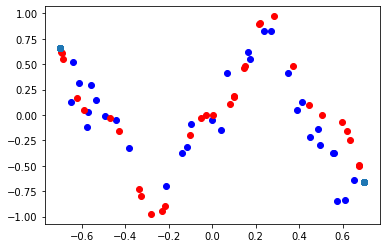

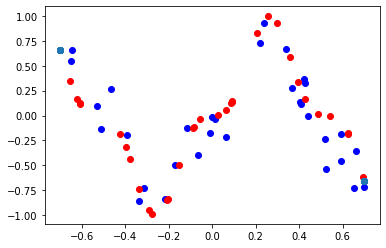

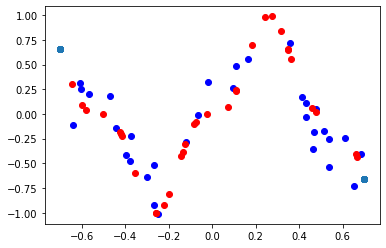

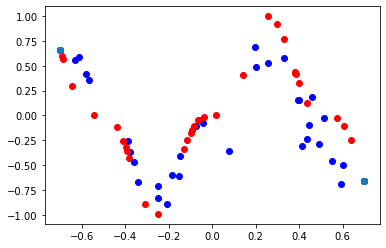

In [29]:
#for x_rd,y_rd,u_rd in xt_rd,u:
#figure()
for j in range(4):
    fig = plt.figure()
    plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
    
    plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
    plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
    plt.show()
    
    
#plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
#plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# for x_rd,y_rd,u_rd in xt_rd,u:
#     figure()
#     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
#     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


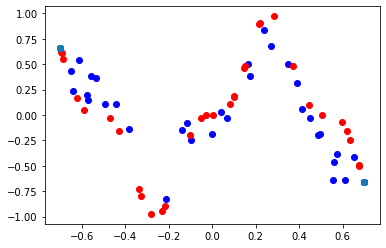

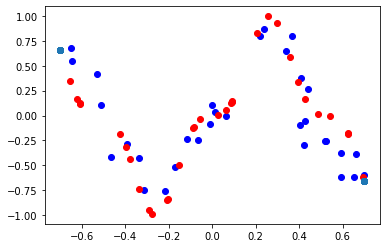

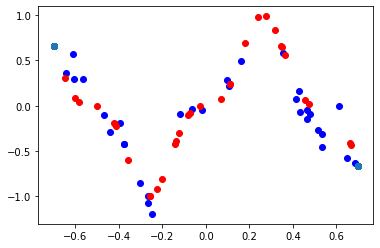

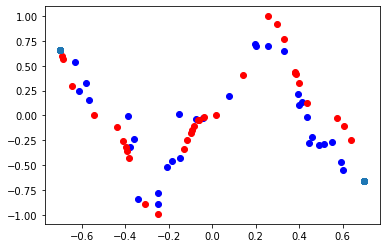

In [24]:
#for x_rd,y_rd,u_rd in xt_rd,u:
#figure()
for j in range(4):
    fig = plt.figure()
    plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
    
    plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
    plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
    plt.show()
    
    
#plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
#plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# for x_rd,y_rd,u_rd in xt_rd,u:
#     figure()
#     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
#     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


In [77]:
#rd_set